In [81]:
import matplotlib.pyplot as plot
import numpy as np
import os
import pandas as pd
import pandas.io.json as pj
import psycopg2
from statsmodels.tsa.api import ExponentialSmoothing

In [82]:
def load_query(query):
    conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR'))
    samples = pd.read_sql_query(query, conn)
    conn.close()
    return samples

Y-axis format function from https://stackoverflow.com/a/40573071

In [89]:
from matplotlib.ticker import FuncFormatter

def format_bytes(y, pos):
    decades = [1e12, 1e9, 1e6, 1e3, 1e0]
    suffix  = ["TB", "GB", "MB", "kB", "B"]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])
    return y

def format_exp(y, pos):
    decades = [1e12, 1e9, 1e6, 1e3, 1e0]
    suffix  = ["T", "B", "M", "K", ""]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])
    return y

In [90]:
chunk_rows_raw = load_query("""
SELECT
  SUM(n_live_tup) AS value,
  to_timestamp(lower(ranges[1])/10^6) AS time
FROM chunk_relation_size('metric_samples') AS m
JOIN pg_stat_user_tables AS t
  ON CONCAT(t.schemaname, '.', t.relname) = m.chunk_table
GROUP BY time
ORDER BY time;
""")
print(chunk_rows_raw.head(5))

   value                      time
0    0.0 2019-12-10 12:00:00+00:00
1    0.0 2019-12-10 13:00:00+00:00
2    0.0 2019-12-10 14:00:00+00:00
3    0.0 2019-12-10 15:00:00+00:00
4    0.0 2019-12-10 16:00:00+00:00


In [91]:
chunk_rows = chunk_rows_raw.set_index('time').resample('1h').max()
print(chunk_rows.head(2))

                           value
time                            
2019-12-10 12:00:00+00:00    0.0
2019-12-10 13:00:00+00:00    0.0


In [101]:
chunk_size_raw = load_query("""
SELECT
    MAX(table_name) AS table,
    to_timestamp(lower(ranges[1])/10^6) AS time,
    SUM(total_bytes)
FROM _timescaledb_catalog.hypertable, chunk_relation_size(table_name::text)
WHERE hypertable.table_name LIKE 'metric%' 
GROUP BY time
ORDER BY 1, 2;
""")
print(chunk_size_raw.head(5))

            table                      time      sum
0  metric_samples 2019-12-10 12:00:00+00:00  32768.0
1  metric_samples 2019-12-10 13:00:00+00:00  32768.0
2  metric_samples 2019-12-10 14:00:00+00:00  32768.0
3  metric_samples 2019-12-10 15:00:00+00:00  32768.0
4  metric_samples 2019-12-10 16:00:00+00:00  32768.0


In [154]:
chunk_size = pd.pivot(chunk_size_raw, index='time', columns='table', values='sum').resample('1h').max()
print(chunk_size.head(2))

table                      metric_samples
time                                     
2019-12-10 12:00:00+00:00         32768.0
2019-12-10 13:00:00+00:00         32768.0


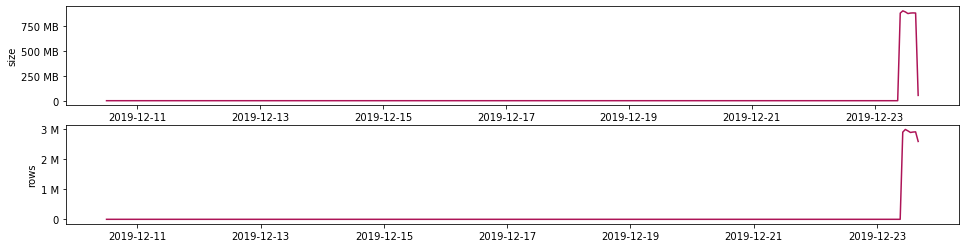

In [103]:
%matplotlib inline
palette_key = '#AD1457'

fig, ax = plot.subplots(nrows=2, figsize=(16, 4))

ax[0].plot(chunk_size, color=palette_key)
ax[0].yaxis.set_major_formatter(FuncFormatter(format_bytes))
ax[0].yaxis.set_label_text('size')

ax[1].plot(chunk_rows, color=palette_key)
ax[1].yaxis.set_major_formatter(FuncFormatter(format_exp))
ax[1].yaxis.set_label_text('rows')

fig.show()

This graph shows chunk size in rows and bytes for live (recent and still-uncompressed) chunks.

In [120]:
chunk_compressed_raw = load_query("""
SELECT
  cc.hypertable_name,
  cc.chunk_name,
  h.compressed_hypertable_id,
  c.compressed_chunk_id,
  cs.uncompressed_heap_size + cs.uncompressed_toast_size AS uncompressed_data_size,
  cs.uncompressed_index_size,
  cs.compressed_heap_size + cs.compressed_toast_size AS compressed_data_size,
  cs.compressed_index_size
FROM timescaledb_information.compressed_chunk_stats AS cc
JOIN _timescaledb_catalog.hypertable AS h
ON cc.hypertable_name::text = h.table_name::text
JOIN _timescaledb_catalog.chunk AS c
ON cc.chunk_name::text = CONCAT(c.schema_name, '.', c.table_name)
JOIN _timescaledb_catalog.compression_chunk_size AS cs
ON cs.compressed_chunk_id = c.compressed_chunk_id
WHERE cc.compression_status = 'Compressed';
""")
print(chunk_compressed_raw.head(5))

  hypertable_name                                chunk_name  \
0  metric_samples  _timescaledb_internal._hyper_1_687_chunk   
1  metric_samples  _timescaledb_internal._hyper_1_690_chunk   
2  metric_samples  _timescaledb_internal._hyper_1_692_chunk   
3  metric_samples  _timescaledb_internal._hyper_1_694_chunk   
4  metric_samples  _timescaledb_internal._hyper_1_696_chunk   

   compressed_hypertable_id  compressed_chunk_id  uncompressed_data_size  \
0                         6                  703               322166784   
1                         6                  705               322256896   
2                         6                  711               323665920   
3                         6                  745               322461696   
4                         6                  748               322461696   

   uncompressed_index_size  compressed_data_size  compressed_index_size  
0                622002176              14991360                1064960  
1               

In [124]:
def data_ratio(row):
    return row['compressed_data_size'] / float(row['uncompressed_data_size'])

def index_ratio(row):
    return row['compressed_index_size'] / float(row['uncompressed_index_size'])

def total_ratio(row):
    return (row['compressed_data_size'] + row['compressed_index_size']) / float(row['uncompressed_data_size'] + row['uncompressed_index_size'])

chunk_compressed_table = chunk_compressed_raw.drop(columns=[
    'hypertable_name', 'chunk_name', 'compressed_hypertable_id', 'compressed_chunk_id'
])
chunk_compressed_table['data_ratio'] = chunk_compressed_table.apply(lambda row: data_ratio(row), axis=1)
chunk_compressed_table['index_ratio'] = chunk_compressed_table.apply(lambda row: index_ratio(row), axis=1)
chunk_compressed_table['total_ratio'] = chunk_compressed_table.apply(lambda row: total_ratio(row), axis=1)
chunk_compressed_table.head(5)

,uncompressed_data_size,uncompressed_index_size,compressed_data_size,compressed_index_size,data_ratio,index_ratio,total_ratio
0,322166784,622002176,14991360,1064960,0.046533,0.001712,0.017006
1,322256896,622485504,15048704,1064960,0.046698,0.001711,0.017056
2,323665920,625516544,15482880,1130496,0.047836,0.001807,0.017503
3,322461696,620290048,15007744,1064960,0.046541,0.001717,0.017049
4,322461696,621641728,15007744,1081344,0.046541,0.001739,0.017042


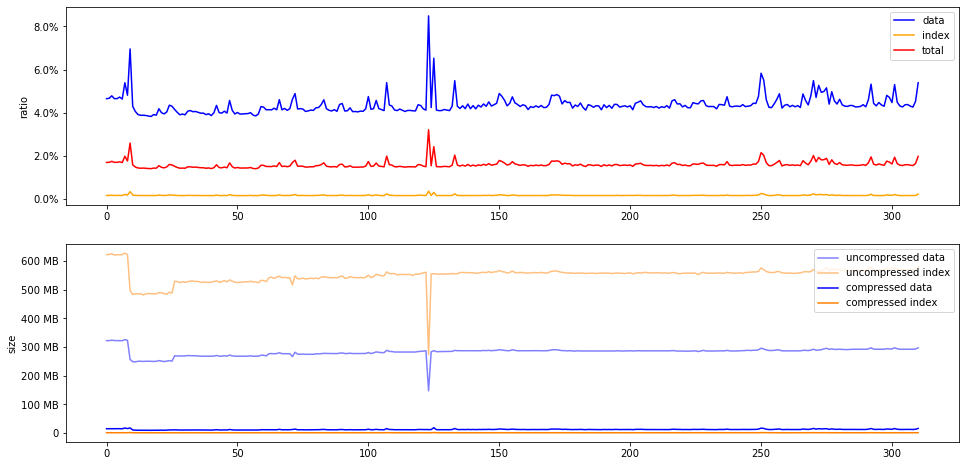

In [153]:
fig, ax = plot.subplots(nrows=2, figsize=(16, 8))

def format_pct(y, pos):
    return f'{round(y * 100)}%'

ax[0].plot(chunk_compressed_table['data_ratio'], label='data', color='blue')
ax[0].plot(chunk_compressed_table['index_ratio'], label='index', color='orange')
ax[0].plot(chunk_compressed_table['total_ratio'], label='total', color='red')
ax[0].legend(loc='upper right')
ax[0].yaxis.set_major_formatter(FuncFormatter(format_pct))
ax[0].yaxis.set_label_text('ratio')

ax[1].plot(chunk_compressed_table['uncompressed_data_size'], label='uncompressed data', color=(0, 0, 1.0, 0.5))
ax[1].plot(chunk_compressed_table['uncompressed_index_size'], label='uncompressed index', color=(1.0, 0.5, 0, 0.5))
ax[1].plot(chunk_compressed_table['compressed_data_size'], label='compressed data', color=(0, 0, 1.0, 1.0))
ax[1].plot(chunk_compressed_table['compressed_index_size'], label='compressed index', color=(1.0, 0.5, 0, 1.0))
ax[1].legend(loc='upper right')
ax[1].yaxis.set_major_formatter(FuncFormatter(format_bytes))
ax[1].yaxis.set_label_text('size')

fig.show()

This graph shows chunk size in bytes for historical (compressed) chunks.